<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%205/Assignment/Pytorch_Review_Toko_Baju_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

## Data Preparation

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)

df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [ ]:
df.dropna(inplace=True)

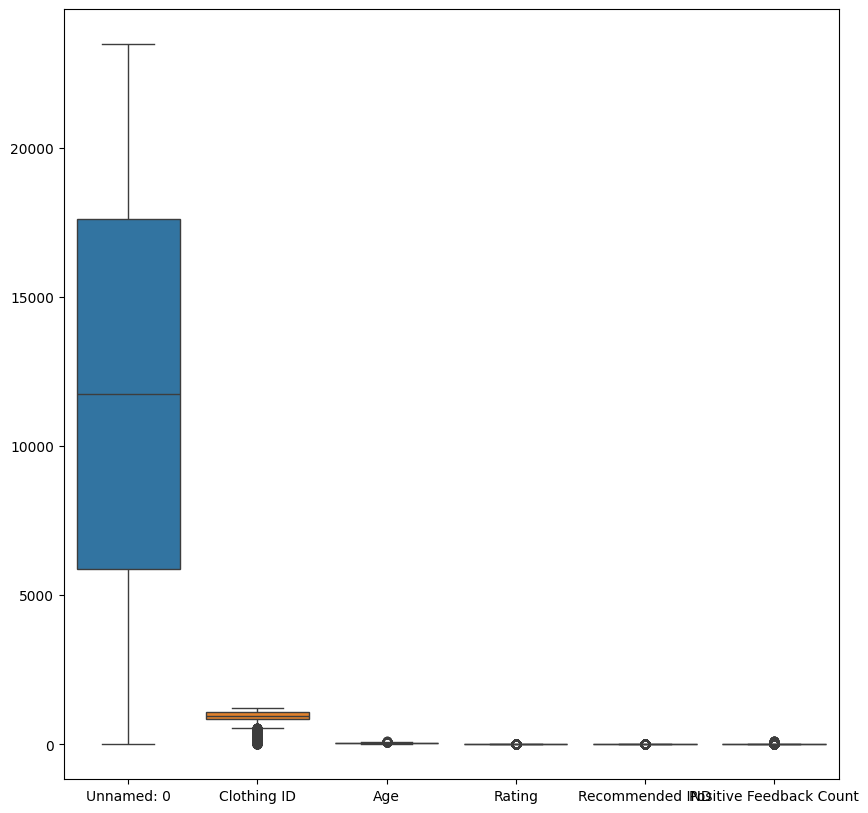

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.show()

## Pre-Processing Data

In [ ]:
df = df[['Review Text', 'Rating']].copy()
df.dropna(inplace=True)

df['Label'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)
texts = df['Review Text'].values
labels = df['Label'].values

In [ ]:
# Tokenizing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=200)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

# Convert to Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

## RNN Model

###Recurrent Neural Network (RNN)

Pada RNN, hidden state diperbarui menggunakan input saat ini dan hidden state sebelumnya:

$$
h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)
$$

Output (jika digunakan secara langsung):

$$
y_t = W_{hy} h_t + b_y
$$

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        out = output[:, -1, :]
        out = self.fc(out)
        return torch.sigmoid(out).squeeze()

In [ ]:
#Hitung Class Weights
counts = Counter(y_train)
total = sum(counts.values())
weight_0 = total / counts[0]
weight_1 = total / counts[1]
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float32).to('cuda')

# Custom Weighted Loss
criterion = nn.BCELoss(reduction='none')
def weighted_loss(outputs, targets):
    weights = torch.where(targets == 1, class_weights[1], class_weights[0])
    return (criterion(outputs, targets) * weights).mean()

In [ ]:
# Inisialisasi Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNClassifier(vocab_size=10000, embedding_dim=128, hidden_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = weighted_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Eval
    model.eval()
    all_preds, all_labels = [], []
    eval_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = weighted_loss(outputs, labels)
            eval_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_loss /= len(test_loader)
    test_losses.append(eval_loss)
    preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]
    test_acc = accuracy_score(all_labels, preds_bin)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {eval_loss:.4f}, Test Acc: {test_acc:.4f}")

100%|██████████| 246/246 [00:01<00:00, 130.14it/s]


Epoch 1, Train Loss: 0.4830, Test Loss: 0.8973, Test Acc: 0.8271


100%|██████████| 246/246 [00:01<00:00, 170.11it/s]


Epoch 2, Train Loss: 0.4389, Test Loss: 0.9258, Test Acc: 0.8223


100%|██████████| 246/246 [00:00<00:00, 303.70it/s]


Epoch 3, Train Loss: 0.3935, Test Loss: 1.0013, Test Acc: 0.8012


100%|██████████| 246/246 [00:00<00:00, 285.55it/s]


Epoch 4, Train Loss: 0.4375, Test Loss: 1.0166, Test Acc: 0.8251


100%|██████████| 246/246 [00:00<00:00, 298.29it/s]


Epoch 5, Train Loss: 0.3387, Test Loss: 1.0614, Test Acc: 0.8342


100%|██████████| 246/246 [00:00<00:00, 301.45it/s]


Epoch 6, Train Loss: 0.3126, Test Loss: 1.1003, Test Acc: 0.8342


100%|██████████| 246/246 [00:00<00:00, 294.84it/s]


Epoch 7, Train Loss: 0.3462, Test Loss: 1.2218, Test Acc: 0.8350


100%|██████████| 246/246 [00:01<00:00, 245.26it/s]


Epoch 8, Train Loss: 0.2905, Test Loss: 1.1988, Test Acc: 0.8368


100%|██████████| 246/246 [00:01<00:00, 234.10it/s]


Epoch 9, Train Loss: 0.4007, Test Loss: 1.2435, Test Acc: 0.8266


100%|██████████| 246/246 [00:00<00:00, 288.87it/s]


Epoch 10, Train Loss: 0.2477, Test Loss: 1.2231, Test Acc: 0.8324


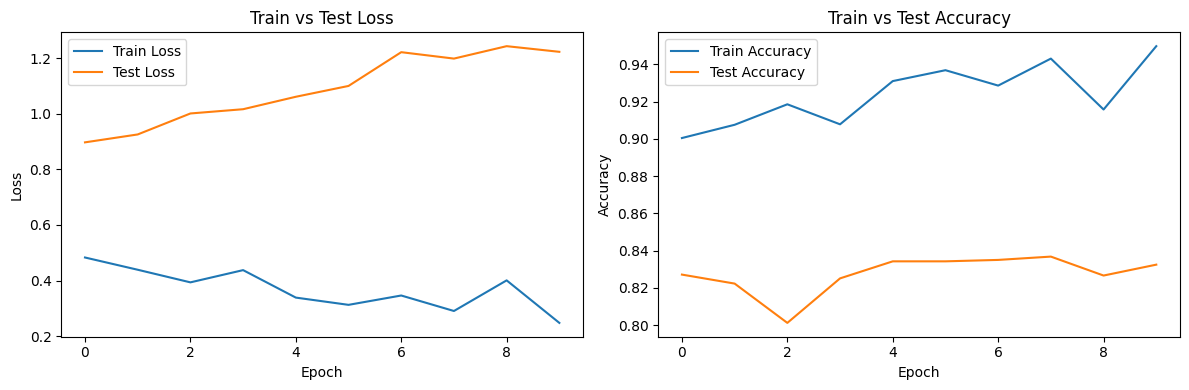

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Loss Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        prob = torch.sigmoid(output)
        preds = (prob > 0.5).float()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(prob.cpu().numpy())

# Skor evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_score)

print(f"Akurasi : {acc:.4f}")
print(f"Presisi : {prec:.4f}")
print(f"Recall  : {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC     : {auc_score:.4f}")

Akurasi : 0.7824
Presisi : 0.7824
Recall  : 1.0000
F1-Score: 0.8779
AUC     : 0.8765


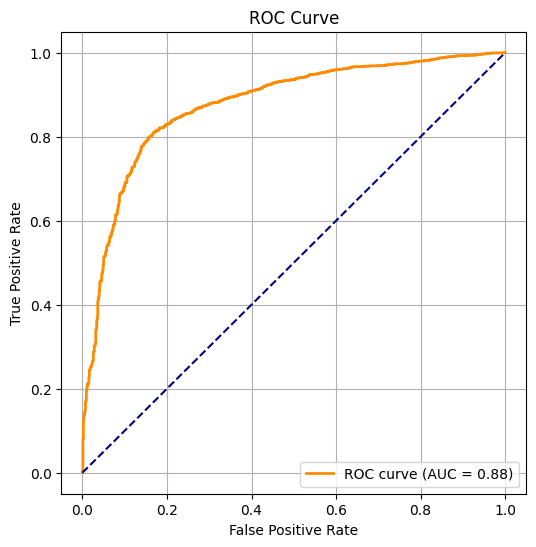

In [ ]:
# ROC Curve
from sklearn.metrics import auc as sk_auc
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = sk_auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## LSTM Model

###Long Short-Term Memory (LSTM)

LSTM memiliki 3 gerbang utama: **Forget Gate**, **Input Gate**, dan **Output Gate**.

- **Forget Gate:**
$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

- **Input Gate:**
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

- **Cell State Update:**
$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

- **Output Gate:**
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
$$
h_t = o_t * \tanh(C_t)
$$

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        output, (hn, cn) = self.lstm(x)
        out = output[:, -1, :]  # ambil hidden state terakhir
        out = self.fc(out)
        return torch.sigmoid(out).squeeze()

# Inisialisasi ulang model LSTM
model = LSTMClassifier(vocab_size=10000, embedding_dim=128, hidden_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Reset history
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = weighted_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Eval
    model.eval()
    all_preds, all_labels = [], []
    eval_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = weighted_loss(outputs, labels)
            eval_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_loss /= len(test_loader)
    test_losses.append(eval_loss)
    preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]
    test_acc = accuracy_score(all_labels, preds_bin)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {eval_loss:.4f}, Test Acc: {test_acc:.4f}")

100%|██████████| 246/246 [00:01<00:00, 239.06it/s]


Epoch 1, Train Loss: 1.1217, Test Loss: 0.8339, Test Acc: 0.7925


100%|██████████| 246/246 [00:00<00:00, 267.23it/s]


Epoch 2, Train Loss: 0.7911, Test Loss: 0.7334, Test Acc: 0.8167


100%|██████████| 246/246 [00:01<00:00, 184.17it/s]


Epoch 3, Train Loss: 0.6270, Test Loss: 0.7111, Test Acc: 0.8576


100%|██████████| 246/246 [00:01<00:00, 168.96it/s]


Epoch 4, Train Loss: 0.5547, Test Loss: 0.7200, Test Acc: 0.8228


100%|██████████| 246/246 [00:00<00:00, 247.37it/s]


Epoch 5, Train Loss: 0.4542, Test Loss: 0.7199, Test Acc: 0.8487


100%|██████████| 246/246 [00:00<00:00, 265.84it/s]


Epoch 6, Train Loss: 0.3706, Test Loss: 0.7385, Test Acc: 0.8602


100%|██████████| 246/246 [00:00<00:00, 270.63it/s]


Epoch 7, Train Loss: 0.3132, Test Loss: 0.8068, Test Acc: 0.8480


100%|██████████| 246/246 [00:01<00:00, 224.07it/s]


Epoch 8, Train Loss: 0.2714, Test Loss: 0.9019, Test Acc: 0.8047


100%|██████████| 246/246 [00:02<00:00, 122.52it/s]


Epoch 9, Train Loss: 0.2308, Test Loss: 1.0091, Test Acc: 0.8368


100%|██████████| 246/246 [00:00<00:00, 263.13it/s]


Epoch 10, Train Loss: 0.1862, Test Loss: 1.0008, Test Acc: 0.8520


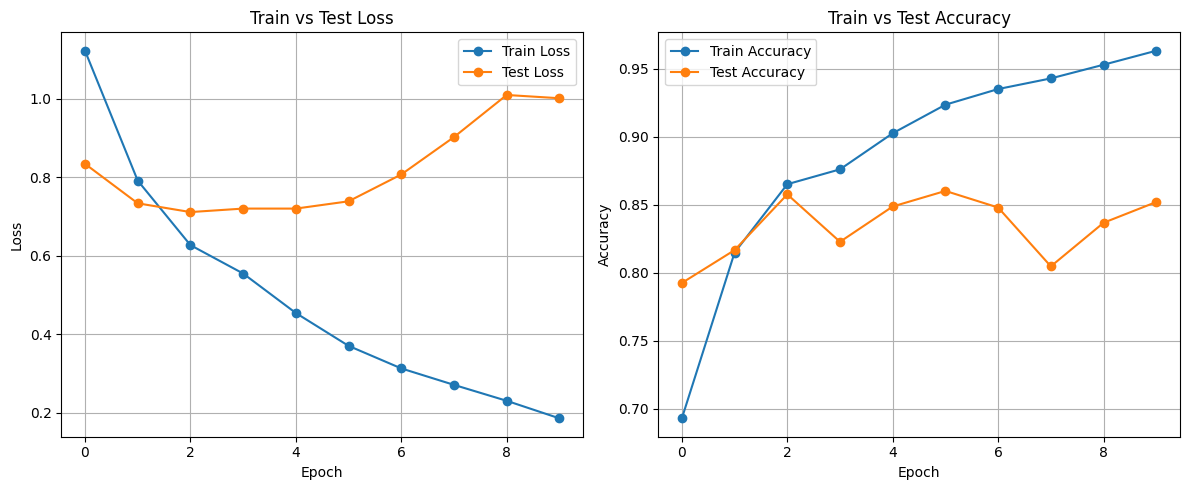

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)

# Grafik Akurasi
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        prob = torch.sigmoid(output)
        preds = (prob > 0.5).float()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(prob.cpu().numpy())

# Skor evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_score)

print(f"Akurasi : {acc:.4f}")
print(f"Presisi : {prec:.4f}")
print(f"Recall  : {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC     : {auc_score:.4f}")

Akurasi : 0.7824
Presisi : 0.7824
Recall  : 1.0000
F1-Score: 0.8779
AUC     : 0.9235


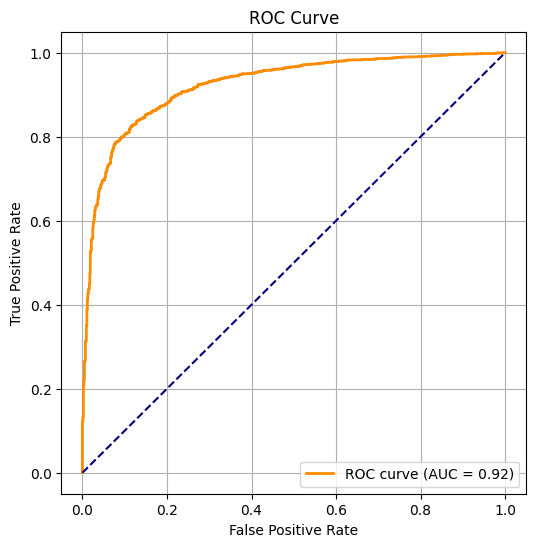

In [ ]:
# ROC Curve
from sklearn.metrics import auc as sk_auc
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = sk_auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## GRU Model

### Gated Recurrent Unit (GRU)

GRU menyederhanakan LSTM dengan dua gerbang: **Update Gate** dan **Reset Gate**.

- **Update Gate:**
$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
$$

- **Reset Gate:**
$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
$$

- **Candidate Activation:**
$$
\tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t])
$$

- **Final Hidden State:**
$$
h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
$$

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        output, hn = self.gru(x)
        out = output[:, -1, :]  # ambil output terakhir
        out = self.fc(out)
        return torch.sigmoid(out).squeeze()

In [ ]:
# Inisialisasi ulang model GRU
model = GRUClassifier(vocab_size=10000, embedding_dim=128, hidden_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = weighted_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Eval
    model.eval()
    all_preds, all_labels = [], []
    eval_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = weighted_loss(outputs, labels)
            eval_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_loss /= len(test_loader)
    test_losses.append(eval_loss)
    preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]
    test_acc = accuracy_score(all_labels, preds_bin)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {eval_loss:.4f}, Test Acc: {test_acc:.4f}")

100%|██████████| 246/246 [00:01<00:00, 244.00it/s]


Epoch 1, Train Loss: 1.1158, Test Loss: 0.8615, Test Acc: 0.7597


100%|██████████| 246/246 [00:00<00:00, 261.28it/s]


Epoch 2, Train Loss: 0.7564, Test Loss: 0.6969, Test Acc: 0.8330


100%|██████████| 246/246 [00:00<00:00, 266.91it/s]


Epoch 3, Train Loss: 0.6061, Test Loss: 0.6599, Test Acc: 0.8492


100%|██████████| 246/246 [00:00<00:00, 263.81it/s]


Epoch 4, Train Loss: 0.5077, Test Loss: 0.6705, Test Acc: 0.8551


100%|██████████| 246/246 [00:00<00:00, 265.14it/s]


Epoch 5, Train Loss: 0.4052, Test Loss: 0.7102, Test Acc: 0.8663


100%|██████████| 246/246 [00:01<00:00, 220.35it/s]


Epoch 6, Train Loss: 0.3516, Test Loss: 0.7427, Test Acc: 0.8551


100%|██████████| 246/246 [00:01<00:00, 213.18it/s]


Epoch 7, Train Loss: 0.2779, Test Loss: 0.7786, Test Acc: 0.8624


100%|██████████| 246/246 [00:00<00:00, 261.38it/s]


Epoch 8, Train Loss: 0.2301, Test Loss: 0.9842, Test Acc: 0.8780


100%|██████████| 246/246 [00:00<00:00, 258.81it/s]


Epoch 9, Train Loss: 0.1924, Test Loss: 0.9425, Test Acc: 0.8668


100%|██████████| 246/246 [00:01<00:00, 201.18it/s]


Epoch 10, Train Loss: 0.1683, Test Loss: 1.1235, Test Acc: 0.8736


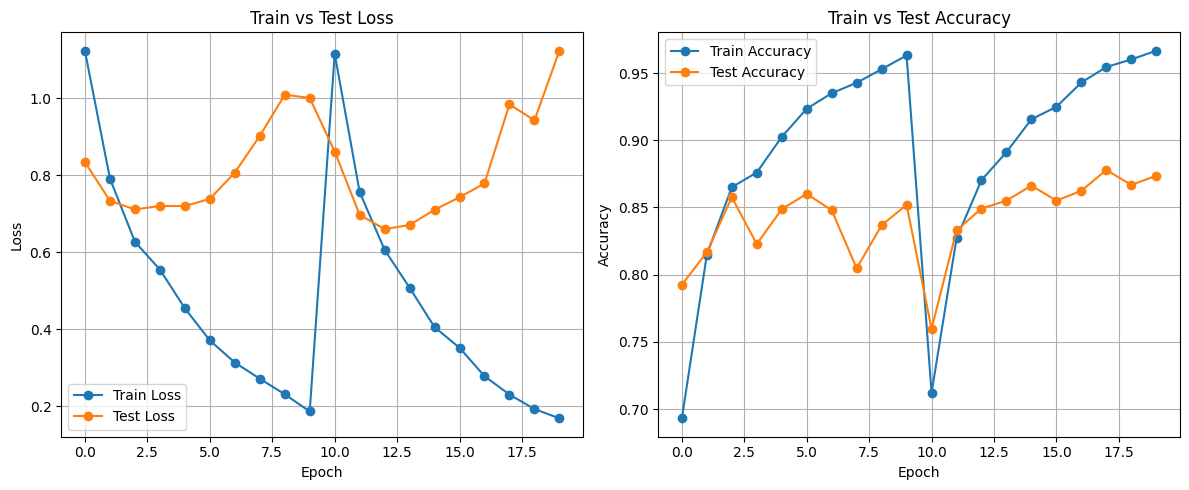

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)

# Grafik Akurasi
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        prob = torch.sigmoid(output)
        preds = (prob > 0.5).float()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(prob.cpu().numpy())

# Skor evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_score)

print(f"Akurasi : {acc:.4f}")
print(f"Presisi : {prec:.4f}")
print(f"Recall  : {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC     : {auc_score:.4f}")

Akurasi : 0.7824
Presisi : 0.7824
Recall  : 1.0000
F1-Score: 0.8779
AUC     : 0.9209


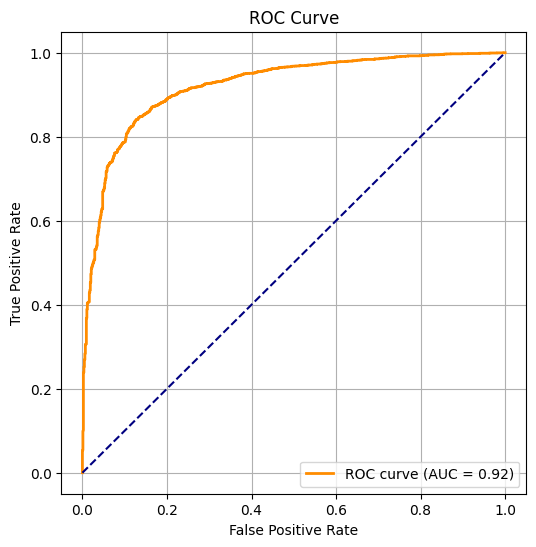

In [ ]:
# ROC Curve
from sklearn.metrics import auc as sk_auc
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = sk_auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Metrik Evaluasi


###Accuracy
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

---

###Precision
$$
Precision = \frac{TP}{TP + FP}
$$

---

###Recall
$$
Recall = \frac{TP}{TP + FN}
$$

---

###F1-Score
$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$

---

###AUC (Area Under Curve)
AUC mengukur area di bawah kurva **ROC (Receiver Operating Characteristic)**.

- ROC adalah plot **True Positive Rate (TPR)** vs **False Positive Rate (FPR)**:

$$
TPR = \frac{TP}{TP + FN}, \quad FPR = \frac{FP}{FP + TN}
$$

## **Persamaan Matematis dan Teknik Tambahan untuk Meningkatkan Performa Model**

---

### 1. Regularisasi L2 (Weight Decay)

**L2 Regularization** menambahkan penalti terhadap bobot besar agar model tidak terlalu kompleks:

- Total loss:
$$
L_{total} = L_{data} + \lambda \sum_{i} w_i^2
$$

- Di mana:
  - \( L_{data} \): loss asli (seperti cross-entropy)
  - \( \lambda \): koefisien regularisasi (semakin besar, semakin kuat penalti)
  - \( w_i \): bobot parameter model

---

### 2. Learning Rate Scheduler

**Learning Rate Scheduler** menyesuaikan laju belajar selama training untuk stabilitas dan konvergensi cepat.

- Contoh Exponential Decay:
$$
\eta_t = \eta_0 \cdot e^{-\lambda t}
$$

- Di mana:
  - \( \eta_0 \): learning rate awal
  - \( \eta_t \): learning rate di epoch ke-\( t \)
  - \( \lambda \): decay rate

---

### 3. Bidirectional RNN (LSTM/GRU)

Menggabungkan dua arah pemrosesan:
- Forward: dari \( t = 1 \to T \)
- Backward: dari \( t = T \to 1 \)

- Output gabungan:
$$
\overrightarrow{h_t}, \ \overleftarrow{h_t} \Rightarrow h_t = [\overrightarrow{h_t}; \overleftarrow{h_t}]
$$

Gabungan ini memperkaya konteks karena model melihat input dari dua arah.

---

### 4. Pretrained Word Embedding (Word2Vec, GloVe)

Representasi kata berbasis vektor:

- Misal dua kata \( w_i \) dan \( w_j \), maka:
$$
\text{cosine\_similarity}(w_i, w_j) = \frac{w_i \cdot w_j}{\|w_i\| \|w_j\|}
$$

- Embedding pretrained bisa digunakan dengan layer `Embedding` agar representasi lebih kuat sejak awal training.

---

